In [188]:
import numpy as np
import pandas as pd
import torch

from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs

RDLogger.DisableLog('rdApp.*')

from collections import Counter
from itertools import product

import selfies as sf

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

In [2]:
import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

# 1. Loading data

## 1.1 Loading model

In [3]:
folder_path = "../model_results/ZINC250K_vae_property_obj_ws"

config_path = "vae_property_config.pt"
model_path = "vae_property_model_080.pt"

config = torch.load(f"{folder_path}/{config_path}")

vocab_path = "vae_property_vocab.pt"
vocab = torch.load(f"{folder_path}/{vocab_path}")

model = VAEPROPERTY(vocab, config)
model.load_state_dict(torch.load(f"{folder_path}/{model_path}"))



<All keys matched successfully>

## 1.2 Loading train data

In [4]:
data_folder_path = "../moses/dataset/data/ZINC250K"

file_name = "train.csv"

data = pd.read_csv(f"{data_folder_path}/{file_name}")

In [5]:
data.head() #it has smiles, selfies, logP, qed, SAS, obj values

,SMILES,SELFIES,logP,qed,SAS,obj
0,COCCOc1ccc(CNC(=O)c2cnc3ccc(C)cn23)cc1,[C][O][C][C][O][C][=C][C][=C][Branch2][Ring1][...,2.59792,0.672152,2.174005,1.186756
1,Cc1cc(C(=O)NC(C)(C)c2cccc(F)c2)[nH]n1,[C][C][C][=C][Branch2][Ring1][Branch2][C][=Bra...,2.52232,0.891576,2.577987,1.879891
2,CCc1n[nH]c(SCc2nnnn2-c2cc(C)ccc2F)n1,[C][C][C][=N][NH1][C][Branch2][Ring1][=Branch1...,2.08262,0.724791,2.787800,0.836156
3,COc1ccc(CC(=O)Nc2cccc3ncccc23)cc1,[C][O][C][=C][C][=C][Branch2][Ring1][Branch1][...,3.42460,0.801260,1.647545,2.358755
4,CCOc1ccc(Cl)c(C(=O)Nc2cc(C)nn2CCC#N)n1,[C][C][O][C][=C][C][=C][Branch1][C][Cl][C][Bra...,2.80460,0.876945,2.582261,1.802464


### 1.2.1 generate whole_latent_data

In [6]:
np.random.seed(42)
samples = data.iloc[np.random.choice(data.shape[0], 1000, replace=False)]

In [7]:
def get_latent_info(mol_smiles, model):
    mu, log_var, z, _ = model.forward_encoder(model.string2tensor(mol_smiles).reshape(1,-1))

    return mu, log_var, z

In [8]:
def get_latent_whole_info(data, model):
    mu_list = []
    log_var_list = []
    z_list = []
    for i in range(len(data)):
        mu, log_var, z = get_latent_info(data["SMILES"].iloc[i], model)
        mu_list.append(mu)
        log_var_list.append(log_var)
        z_list.append(z)

    mu_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in mu_list], columns=["mu"], index=data.index)
    logvar_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in log_var_list], columns=["logvar"], index=data.index)
    z_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in z_list], columns=["z"], index=data.index)

    return mu_df, logvar_df, z_df

In [9]:
mu_df, log_var_df, z_df = get_latent_whole_info(samples, model)

In [10]:
whole_latent_info = pd.concat([samples, mu_df, log_var_df, z_df], axis=1)

In [11]:
whole_latent_info

,SMILES,SELFIES,logP,qed,SAS,obj,mu,logvar,z
38683,CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2,[C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...,2.55190,0.808834,2.786591,1.257578,"[[0.0006688088, -0.04799132, 0.009349651, 0.00...","[[-0.0018990822, -0.0017098114, 0.0023532398, ...","[[-0.34788042, -1.124217, -1.0180868, 0.110421..."
64939,O=C(CCO)N1CCC2(CC(Nc3ncccn3)CO2)C1,[O][=C][Branch1][Ring2][C][C][O][N][C][C][C][B...,0.03090,0.813958,4.044754,0.025037,"[[-0.00095851347, 0.021082483, 0.007405185, 0....","[[4.9378723e-05, -0.0030402318, 0.0017250776, ...","[[-0.066773355, -0.31944117, 0.28933546, -0.61..."
3954,COc1c(CN(CCC#N)Cc2ccccn2)c(C)nn1C,[C][O][C][=C][Branch2][Ring1][C][C][N][Branch1...,2.04800,0.782484,2.591605,1.320817,"[[0.009314321, 0.0017299056, 0.01059019, -0.00...","[[0.00043804199, -0.0008841902, -0.0006967876,...","[[-0.18035033, 0.8279109, -1.5694437, -1.49101..."
120374,CC(C)CCn1c(=O)c2sccc2n2c(=O)[nH]nc12,[C][C][Branch1][C][C][C][C][N][C][=Branch1][C]...,1.44510,0.787737,2.793158,1.145527,"[[0.0019169301, -0.035416692, 0.0028020684, 0....","[[0.0007841289, -0.0021196902, -0.0014276989, ...","[[-0.6388959, 0.10280505, 0.862791, 1.4218786,..."
172861,N#Cc1ccccc1N1CCN(C(=O)CCN2CCCCC2=O)CC1,[N][#C][C][=C][C][=C][C][=C][Ring1][=Branch1][...,1.60948,0.835036,2.200988,1.974191,"[[0.0012648702, 0.018271655, -0.010631787, 0.0...","[[-0.000246834, -0.0021136627, -0.0008503087, ...","[[-1.4254918, 0.626089, -0.7045371, -0.8695274..."
...,...,...,...,...,...,...,...,...,...
3963,CCOc1ccc(C2NC(=O)NC3=C2C(=O)N(CCC(C)C)C3)cc1,[C][C][O][C][=C][C][=C][Branch2][Ring1][=N][C]...,2.58160,0.833919,2.937811,1.231782,"[[0.0339616, 0.026932195, -0.010883499, 0.0052...","[[0.00015386939, -0.0031673014, -0.0016510524,...","[[-1.81391, -0.26168096, -0.81667995, 0.461852..."
79890,Cc1cc(C)c(NC(=O)CNc2nc3ccccc3nc2C)c(C)c1,[C][C][=C][C][Branch1][C][C][=C][Branch2][Ring...,3.91408,0.758875,2.142944,1.651432,"[[0.024229053, -0.001015991, 0.01246443, 0.001...","[[-0.00049760565, -0.00026541203, -0.000601597...","[[1.4540688, -0.060145635, 0.72156954, 2.17412..."
15295,Cc1cccc(N2CC(C(=O)N3CCOC(C)C3)CC2=O)c1C,[C][C][=C][C][=C][C][Branch2][Ring1][#Branch2]...,1.90364,0.837225,2.955786,1.230338,"[[0.0052305683, 0.016977385, -0.02318297, -0.0...","[[-0.0023915023, -0.0017191097, -0.0006081946,...","[[-0.8468702, 0.38266927, -0.011780726, -0.366..."
218373,CN(Cc1cccnc1)S(=O)(=O)N1CCNCC1,[C][N][Branch1][#Branch2][C][C][=C][C][=C][N][...,-0.33660,0.812984,2.360259,1.704662,"[[-0.008896768, 0.05477962, -0.019030368, 0.02...","[[0.0043442287, -0.005062647, -0.00561619, 0.0...","[[0.09740945, 1.4767339, 0.62416536, -2.151724..."


## 1.2.2 for test mol, generate molecular diagram

In [81]:
props = ["logP", "qed", "SAS", "obj"]

for idx, prop in enumerate(props):
    print(idx,prop)

0 logP
1 qed
2 SAS
3 obj


In [200]:
def sample_latent_space(mu, model, ranges=(3,3), latent_dim=128, n_trials=1000, 
                        n_grid=6, temp=0.01, orthogonal_vec=(None,None), save_name=None, prop_save_name=None,
                        props=None): #note : props should be list of properties among "logP", "qed", "SA", "obj

    np.random.seed(42)

    if orthogonal_vec[0] is None or orthogonal_vec[1] is None: # orthogonal vectors are not given -> set two basis vectors
        orthogonal_vec = np.eye(latent_dim)[np.random.randint(0, latent_dim, 2)]

    x_range, y_range = ranges

    dx = np.linspace(-x_range, x_range, 2*n_grid+1)
    dy = np.linspace(-y_range, y_range, 2*n_grid+1)

    grid = pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1))

    prop_grid_list = []

    for _ in range(len(props)):
        prop_grid_list.append(pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1)))

    for i_x, i_y in tqdm(product(range(2*n_grid+1), range(2*n_grid+1)), desc='whole_iters', total=(2*n_grid+1)**2): #each data points
        z_point = mu + dx[i_x]*orthogonal_vec[0] + dy[i_y]*orthogonal_vec[1] # move the point to the direction of the unit vector
        most_freq_mol, freq_df = decode_z(z_point, model, n_trials, temp)

        grid.iloc[i_x, i_y] = most_freq_mol

        for idx, prop in enumerate(props):
            prop_grid_list[idx].iloc[i_x, i_y] = calc_avg_prop(freq_df, props=prop)
    
    if save_name is not None:
        grid.to_csv(save_name)
    
    if prop_save_name is not None:
        for idx, prop in enumerate(props):
            prop_grid_list[idx].to_csv(f"{prop_save_name}_{prop}.csv")
    
    return grid

def decode_z(z, model, n_trials, temp):
    # decode n_trials times from z using the model sample function, and pick most frequent one
    z_input = torch.tensor(z).repeat(n_trials).reshape(n_trials, -1)

    z_input = z_input.float()

    decoded_mols = model.sample(n_batch=z_input.shape[0], z=z_input, temp=temp)

    valid_decoded_mols = [Chem.MolFromSmiles(mol) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]
    
    print(f"ratio of valid molecules : {len(valid_decoded_mols)}/{n_trials}")

    canon_dec_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(mol), canonical=True) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]

    mol_freq = Counter(canon_dec_mols)

    most_freq_mol, _ = find_argmax(mol_freq)

    freq_df = get_mol_freq(mol_freq)

    return most_freq_mol, freq_df

def find_argmax(counter):
    # Get the most common element and its count
    most_common_element = counter.most_common(1)
    if most_common_element:
        element, count = most_common_element[0]
        return element, count
    else:
        return None, None

def get_mol_freq(counter):
    # Get the most common element and its count
    mols = counter.keys()
    counts = counter.values()

    freq_df = pd.DataFrame({"mols":mols, "counts":counts})

    return freq_df

def calc_avg_prop(freq_df, props=None):
    if props is None:
        return None
    
    mols = freq_df["mols"] # smiles
    counts = freq_df["counts"]

    avg_prop = 0
    total_count = 0

    for mol, count in zip(mols, counts):
        prop = get_mol_prop(mol, props) # if mol is invalid, skip that molecule and exclude from the calculation of average property.

        if prop is not None:
            total_count += count
            avg_prop += prop*count

    avg_prop /= total_count

    return avg_prop

def get_mol_prop(mol, props): # get the property of the molecule
    chemmol = Chem.MolFromSmiles(mol)

    if chemmol is None:
        return None

    if props == "logP":
        return logP(chemmol)
    elif props == "qed":
        return QED(chemmol)
    elif props == "SA":
        return SA(chemmol)
    elif props == 'obj':
        return 5 * QED(chemmol) - SA(chemmol)
    else:
        return None
    
def plot_freq_mols_with_color(freq_mols_grid_df, save_name=None):
    # plot grid-wise latent space for each molecules
    # and return the color dictionary for each molecule
    
    n_rows, n_cols = freq_mols_grid_df.shape

    mol_positions = {}

    # 그리드의 각 칸에 대해 분자를 추적합니다.
    for i in range(n_rows):
        for j in range(n_cols):
            mol = freq_mols_grid_df.iloc[i, j]
            if mol:  # 빈 셀을 무시합니다.
                mol_smiles = str(mol)
                if mol_smiles not in mol_positions:
                    mol_positions[mol_smiles] = []
                mol_positions[mol_smiles].append((i, j))  # 분자가 존재하는 칸의 위치를 저장합니다.

    # 분자별로 고유한 색을 할당합니다, 단 색상은 중심에 위치한 분자로부터의 tanimoto similarity로 정의됩니다.
    central_mol = freq_mols_grid_df.iloc[n_rows // 2, n_cols // 2]

    unique_colors = {mol_smiles: tuple([calculate_tanomoto_similiarity(mol_smiles, central_mol)]*3) for mol_smiles in mol_positions.keys()}

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))
    # TODO : memorize the position of each unique molecules, and indicate the color on each grid.
    for i in range(n_rows):
        for j in range(n_cols):
            color = unique_colors[freq_mols_grid_df.iloc[i,j]]
            mol = Chem.MolFromSmiles(freq_mols_grid_df.iloc[i,j])

            if mol is not None:
                ax[i,j].add_patch(plt.Rectangle((0,0), 1,1, color=color))
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")
    
    if save_name is not None:
        plt.savefig(save_name, dpi=300)

    plt.show()
    plt.clf() 
    
    return unique_colors

def calculate_tanomoto_similiarity(mol1, mol2):
    fp1 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol1), 2)
    fp2 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol2), 2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)


def plot_freq_mols(freq_mols_grid_info, save_name=None):
    if type(freq_mols_grid_info) is str:
        plot_prop_mols_from_path(freq_mols_grid_info, save_name)
    elif type(freq_mols_grid_info) is pd.DataFrame:
        plot_prop_mols_from_df(freq_mols_grid_info, save_name)
    else:
        raise ValueError("Invalid input type")

def plot_freq_mols_from_path(freq_grid_path, save_name=None):
    freq_mols_grid = pd.read_csv(freq_grid_path, index_col=0)

    plot_freq_mols_from_df(freq_mols_grid, save_name)

def plot_freq_mols_from_df(freq_mols_grid, save_name=None):
    n_rows, n_cols = freq_mols_grid.shape

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i in range(n_rows):
        for j in range(n_cols):
            mol = Chem.MolFromSmiles(freq_mols_grid.iloc[i,j])
            if mol is not None:
                img = Chem.Draw.MolToImage(mol, size=(300,300))
                ax[i,j].imshow(img)
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

def plot_prop_mols(prop_grid_info, save_name=None, prop_name=None):
    if type(prop_grid_info) is str:
        plot_prop_mols_from_path(prop_grid_info, save_name, prop_name)
    elif type(prop_grid_info) is pd.DataFrame:
        plot_prop_mols_from_df(prop_grid_info, save_name, prop_name)
    else:
        raise ValueError("Invalid input type")
    
def plot_prop_mols_from_path(prop_grid_path, save_name=None, prop_name=None):
    prop_grid = pd.read_csv(prop_grid_path, index_col=0)

    plot_prop_mols_from_df(prop_grid, save_name, prop_name)

        
def plot_prop_mols_from_df(prop_df, save_name=None, prop_name=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = prop_df.index
    y = np.arange(len(prop_df.columns))

    X,Y = np.meshgrid(x,y)

    Z = prop_df.values

    print(prop_df)
    print(x)
    print(y)
    print(Z)

    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


    ax.set_title("property surface in subspace of latent space")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(prop_name)

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

In [14]:
test_mol = whole_latent_info.iloc[0]

In [15]:
test_mol

SMILES                       CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2
SELFIES    [C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...
logP                                                  2.5519
qed                                                 0.808834
SAS                                                 2.786591
obj                                                 1.257578
mu         [[0.0006688088, -0.04799132, 0.009349651, 0.00...
logvar     [[-0.0018990822, -0.0017098114, 0.0023532398, ...
z          [[-0.34788042, -1.124217, -1.0180868, 0.110421...
Name: 38683, dtype: object

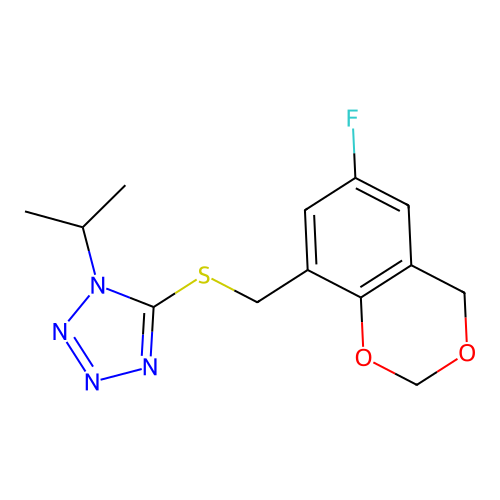

In [16]:
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(test_mol['SMILES']), size=(500,500))


img

In [204]:
ranges_list = [(10,10), (20,20), (30,30)]

temp_list = [0.01, 0.1, 1]

experiments = list(product(ranges_list, temp_list))

v1 = np.ones(config.d_z)
v1 = v1/np.linalg.norm(v1) # 1/sqrt(128)*np.ones(128)

v2 = np.array([1 if i < config.d_z//2 else -1 for i in range(config.d_z)])
v2 = v2/np.linalg.norm(v2) # 1/sqrt(128)*[1,1,1,1,1...,-1(65th coord),-1,-1,-1,-1... -1]

save_folder_path = "figures/two_other_orthogonal_basis"
prop_fname = "test_mol_prop"
mol_fname = "test_mol"

for i, (ranges, temp) in enumerate(experiments):
    print(f"------------- Experiment {i} -------------")
    
    grid = sample_latent_space(test_mol["mu"][0], model, ranges=ranges, temp=temp, n_trials=1000, n_grid=10, orthogonal_vec=(v1,v2),
                               prop_save_name=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv", props=["logP", "SA", "qed", "obj"],
                               save_name=f"{save_folder_path}/csv_folder/{mol_fname}_{i}.csv")
    
    plot_freq_mols(grid, save_name=f"{save_folder_path}/{mol_fname}_{i}.png")

    for prop in ["logP", "SA", "qed", "obj"]:
        plot_prop_mols(prop_grid_info=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv_{prop}.csv", save_name=f"{save_folder_path}/{prop_fname}_{i}_{prop}.png")

------------- Experiment 0 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<17:07,  2.34s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:04<17:35,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:07<17:33,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:09<17:14,  2.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:11<17:01,  2.34s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:14<16:38,  2.30s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:16<16:33,  2.29s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:18<16:37,  2.30s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:21<16:50,  2.34s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:23<17:02,  2.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:25<16:45,  2.34s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:28<16:59,  2.38s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:30<17:09,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:33<17:07,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:35<17:15,  2.43s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:37<17:10,  2.42s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:40<17:03,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:42<16:57,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:45<17:05,  2.43s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:47<17:00,  2.42s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:50<17:04,  2.44s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:52<16:51,  2.42s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:54<16:46,  2.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:57<16:42,  2.40s/it]